## Phase 3: Apply Unsupervised Learning


### K-Means Clustering Overview

K-Means clustering is a method used to group data points based on their similarity. It works by initially selecting a set of central points, known as **centroids**. Each data point is assigned to the nearest centroid, forming clusters. After all points are assigned, the centroids are updated by calculating the average position of the points in each cluster. This process of assigning and updating continues until the centroids stabilize and no longer change significantly.

The objective of K-Means clustering is to partition the data in such a way that points within the same cluster are more similar to each other than to those in other clusters.



### Why We Chose KMeans Clustering

We applied **KMeans clustering** to group products based on their features (e.g., skin type compatibility, product type, and notable effects). This clustering enhances the personalized supervised learning-based recommendation system by organizing products into broader groups that reflect shared characteristics. These clusters can later be used to improve filtering or ranking of product recommendations based on user similarity or preferences.

We selected **KMeans** as our clustering algorithm for the following reasons [2]:

1. **Simplicity and Efficiency**  
   While our current dataset is relatively small (1203 products), we chose KMeans because it is computationally efficient and capable of scaling to much larger datasets in future versions of the system.

2. **Well-Suited for Numeric and Sparse Feature Sets**  
   After preprocessing, our dataset consists entirely of numerical features, including one-hot encoded attributes for product types, skin types, and effects. KMeans performs well in such vector space models, where Euclidean distance between feature vectors is a reliable similarity measure.

3. **Effective for Broad Grouping of Products**  
   Our recommendation system benefits from grouping similar products together so that the model can offer a set of recommendations within the most relevant cluster. KMeans ensures that each product is assigned to exactly one cluster, which helps maintain a clean structure for filtering and explaining recommendations.

4. **Interpretability and Alignment with User Behavior**  
   The centroids generated by KMeans represent the average profile of a cluster. These centroids can be analyzed to identify common skin concerns or product characteristics, making it easier for users or the system to interpret why certain recommendations are made.

5. **Strong Support in Evaluation**  
   Our implementation of KMeans achieved a reasonable **Silhouette Score**, indicating that the clusters are relatively compact and distinct. Additionally, because KMeans includes all data points, no information is lost — ensuring that every product is considered for recommendations.

While density-based clustering methods like DBSCAN can uncover more nuanced relationships, they often exclude data as noise, which is unsuitable for a system where we need to retain all products in the recommendation flow.

Therefore for our application, a general purpose product recommendation engine that must classify all items and support broad personalization **KMeans offers a strong balance of simplicity, interpretability, and performance**.




In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Load your dataset (if not already loaded)
df = pd.read_csv("Dataset/processed_file.csv")

# Drop irrelevant or non-numeric columns
columns_to_drop = [
    'Unnamed: 0', 'product_href', 'product_name', 'product_type', 'brand',
    'notable_effects', 'skintype', 'description', 'picture_src', 'labels'
]
df_clean = df.drop(columns=columns_to_drop)

# Drop rows with missing values (only price_SAR had some)
df_clean = df_clean.dropna()

# Scale the features (important for clustering)
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_clean)

# Optionally, convert the scaled data back to a DataFrame
scaled_df = pd.DataFrame(scaled_data, columns=df_clean.columns)

# Preview the cleaned and scaled data
scaled_df.head()

# Save to a new CSV file
scaled_df.to_csv("Dataset/processed_for_clustering.csv", index=False)


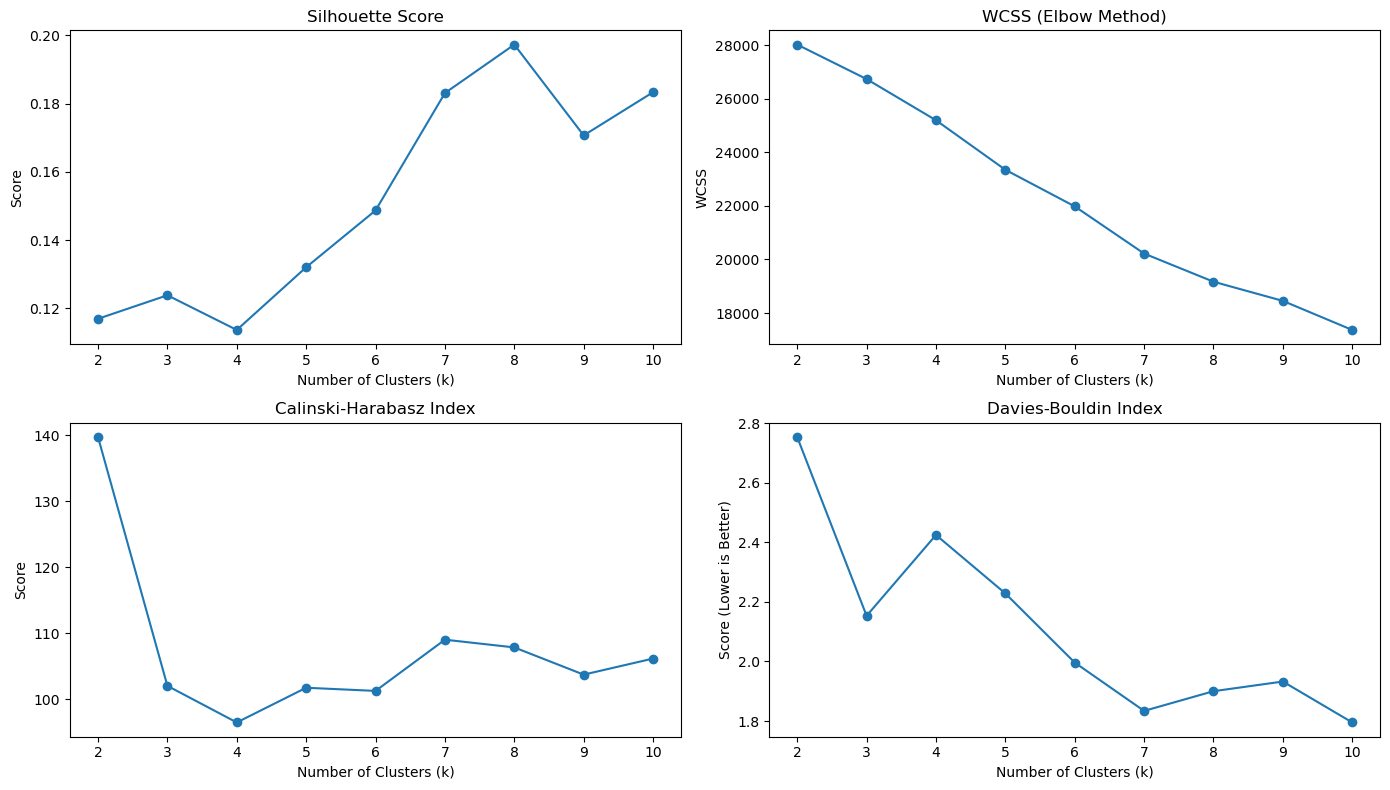

In [2]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Define range of k
k_values = range(2, 11)
sil_scores = []
wcss_values = []
ch_scores = []
db_scores = []

# Evaluate each k
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(scaled_df)
    data = scaled_df.drop('Cluster', axis=1, errors='ignore')
    
    sil_scores.append(silhouette_score(data, labels))
    wcss_values.append(kmeans.inertia_)
    ch_scores.append(calinski_harabasz_score(data, labels))
    db_scores.append(davies_bouldin_score(data, labels))

# Plot
plt.figure(figsize=(14, 8))
plt.subplot(2, 2, 1)
plt.plot(k_values, sil_scores, marker='o')
plt.title('Silhouette Score')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Score')

plt.subplot(2, 2, 2)
plt.plot(k_values, wcss_values, marker='o')
plt.title('WCSS (Elbow Method)')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS')

plt.subplot(2, 2, 3)
plt.plot(k_values, ch_scores, marker='o')
plt.title('Calinski-Harabasz Index')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Score')

plt.subplot(2, 2, 4)
plt.plot(k_values, db_scores, marker='o')
plt.title('Davies-Bouldin Index')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Score (Lower is Better)')

plt.tight_layout()
plt.show()


### Visual Interpretation of Clustering Performance

To better understand the performance of KMeans clustering across different values of *k*, we plotted four key evaluation metrics:

- **Silhouette Score** (higher is better)
- **WCSS (Within-Cluster Sum of Squares)** – shows the "elbow"
- **Calinski-Harabasz Index** (higher is better)
- **Davies-Bouldin Index** (lower is better)

These visuals help us identify the optimal number of clusters and interpret how well-separated and coherent our clusters are. They also support our justification for choosing `k = 6` in our final model.


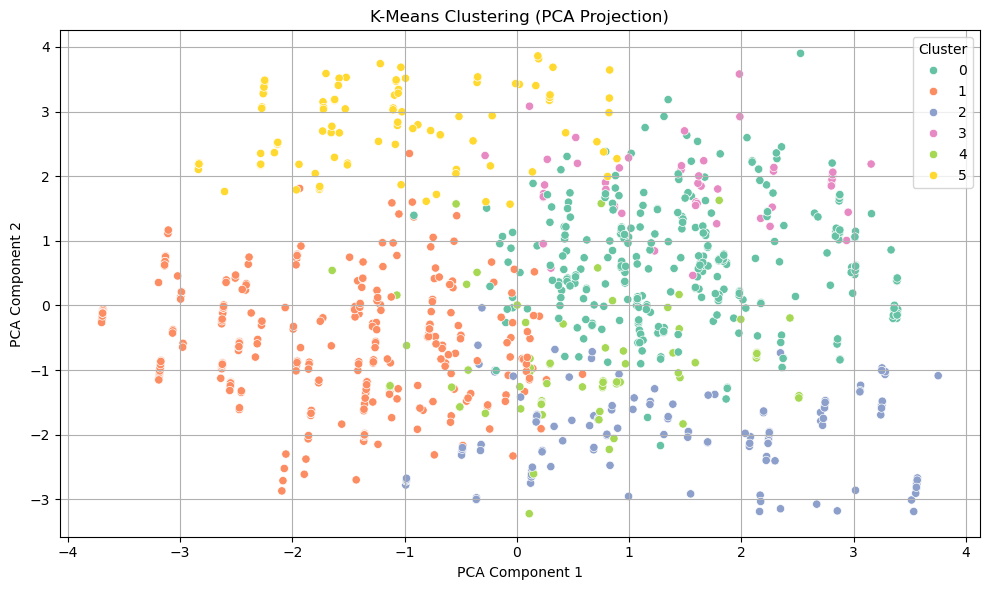

Silhouette Score: 0.1929
WCSS (Total Within-Cluster Sum of Squares): 21133.62
Calinski-Harabasz Index: 117.98
Davies-Bouldin Index: 1.88


In [43]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Apply KMeans
kmeans = KMeans(n_clusters=6, random_state=45)
clusters = kmeans.fit_predict(scaled_df)

# Step 2: Add cluster labels to the dataframe
scaled_df['Cluster'] = clusters

# Step 3: Visualize with PCA (2D)
pca = PCA(n_components=2)
pca_components = pca.fit_transform(scaled_df.drop('Cluster', axis=1))

plt.figure(figsize=(10, 6))
sns.scatterplot(x=pca_components[:, 0], y=pca_components[:, 1], hue=clusters, palette='Set2')
plt.title("K-Means Clustering (PCA Projection)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Cluster")
plt.grid(True)
plt.tight_layout()
plt.show()

# Step 4: Evaluate using Silhouette Score
silhouette = silhouette_score(scaled_df.drop('Cluster', axis=1), clusters)
print(f"Silhouette Score: {silhouette:.4f}")


import pandas as pd
pd.set_option('display.max_columns', None)  # Optional: show all columns


# Total Within-Cluster Sum of Squares
wcss = kmeans.inertia_
print(f"WCSS (Total Within-Cluster Sum of Squares): {wcss:.2f}")

# Compute internal evaluation metrics
calinski_score = calinski_harabasz_score(scaled_df.drop('Cluster', axis=1), clusters)
davies_score = davies_bouldin_score(scaled_df.drop('Cluster', axis=1), clusters)

print(f"Calinski-Harabasz Index: {calinski_score:.2f}")
print(f"Davies-Bouldin Index: {davies_score:.2f}")


After evaluating clustering models using K-Means for values of k ranging from 2 to 10, we selected **k = 6** based on a combination of internal clustering metrics and visual analysis.

Key results at **k = 6**:
- **Silhouette Score**: `0.1929`, indicating moderate cluster separation.
- **WCSS**: `21133.62`, showing good compactness.
- **Calinski-Harabasz Index**: `117.98`, supporting strong inter-cluster dispersion.
- **Davies-Bouldin Index**: `1.88`, reflecting acceptable intra-cluster similarity.

Despite some overlap, the clusters formed at `k = 6` are meaningful and interpretable, making this configuration suitable for further use. The assigned cluster labels will be used as an additional feature in the supervised learning phase to potentially enhance model performance.


### Why BCubed Precision and Recall Were Not Used

BCubed Precision and Recall are **external clustering evaluation metrics** that require **true ground-truth class labels** to assess clustering performance. These metrics evaluate how well a clustering aligns with predefined categories, such as whether products clustered together truly belong to the same known class.

In our dataset, while we have descriptive columns like `product_type`, `notable_effects`, and `skintype`, they serve as **input features** — not as definitive class labels. Each row can belong to **multiple categories simultaneously**, and there is no single true label per product to evaluate against.

As a result, BCubed metrics are not applicable in our case because there is no labeled "truth" to compare our clusters against.

Instead, we rely on **internal clustering metrics**, such as:
- **Silhouette Score**
- **Calinski-Harabasz Index**
- **Davies-Bouldin Index**

These allow us to assess clustering quality based on how compact and well-separated the clusters are.


In [44]:
# Add cluster labels to original scaled data
scaled_df['Cluster'] = clusters

# Save to CSV
scaled_df.to_csv("Dataset/clustered_data_k6.csv", index=False)


Using the Elbow Method, Silhouette Score and other internal evaluation metrics, we determined that k=6 provides a reasonable balance between cluster compactness and interpretability for our dataset.

## How Clusters Are Used to Improve Recommendations
Clustering helps us discover hidden patterns in the dataset by grouping similar products together based on their features. After applying K-Means, each product is assigned to a specific cluster. These clusters can then be used to enhance recommendations in the following way:


- Instead of recommending from the entire dataset, we filter products from the most relevant cluster, ensuring more targeted and meaningful suggestions.

- This improves the efficiency and relevance of recommendations by focusing on products that share similar characteristics.

By leveraging clustering, we introduce an additional layer of personalization that is independent of explicit labels, allowing the system to generalize better and uncover relationships that may not be obvious

## References  
[1] A. Aggarwal, "K-Means Clustering - Introduction," GeeksforGeeks, Aug. 3, 2023. [Online]. Available: https://www.geeksforgeeks.org/k-means-clustering-introduction/

[2] IBM, "K-means clustering," IBM, https://www.ibm.com/think/topics/k-means-clustering 